# Formalia:

Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2021/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday November the 2nd, 2021 at 23:59. Hand in your IPython notebook file (with extension `.ipynb`) via http://peergrade.io/

### Overview

This year's Assignment 2 is all about analyzing the network of The Legend of Zelda: Breath of the Wild.

Note that this time I'm doing the exercises slightly differently in order to clean things up a bit. The issue is that the weekly lectures/exercises include quite a few instructions and intermediate results that are not quite something you guys can meaningfully answer. 

Therefore, in the assignment below, I have tried to reformulate the questions from the weekly exercises into something that is (hopefully) easier to answer. *Then I also note which lectures each question comes from*; that way, you can easily go back and find additional tips & tricks on how to solve things 😇


----

# Part 0: Building the network 

To create our network, we downloaded the Zelda Wiki pages for all characters in BotW (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions!

> * Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the pages with the Zelda API.
> * Show the regular expression(s) you have built and explain in details how it works.

We knew that the hyperlinks in the html text were written with {{ }} or [[ ]]. Therefore we searched for patterns which had this format. 

In [70]:
pattern1 = '\{\{(?:Term|Plural)\|BotW\|(.*?)(?:\|link)?(?:\|display.*?)?\}\}'
pattern2 = '\[\[(.*?)(?:\||\#.*?)?(?:\|.*?)?\]\]'
race_pattern = 'race\s*=\s*(?:\{\{Term\|BotW\|(.*?)\|link\}\}|\[\[(.*?)\]\])'
gender_pattern = 'gender\s*=\s*(\w*)'

We knew that if the link was enclosed in curly brackets, the first two elements in the curly brackets would be Term|Plural|BotW whereafter the name of the link would come up. Also, it was important that the curly brackets also contained the 'link' attribute or else the curly brackets would not be shown as a link in the text. 

# Part 1: Network visualization and basic stats

Visualize the network (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you've already generated the BotW network and extracted the giant connected component. Use the GCC to report the results.

_Exercise 1a_: Stats (see lecture 4 and 5 for more hints)

> * What is the number of nodes in the network? 
> * What is the number of links?
> * Who is the top connected character in BotW? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?
> * Who are the top 5 most connected allies (again in terms of in/out-degree)? 
> * Who are the top 5 most connected enemies -- bosses included -- (again in terms of in/out-degree)?
> * Plot the in- and out-degree distributions. 
>   * What do you observe? 
>   * Can you explain why the in-degree distribution is different from the out-degree distribution?
> * Find the exponent of the degree distribution (by using the `powerlaw` package) for the in- and out-degree distribution. What does it say about our network?
> * Compare the degree distribution of the undirected graph to a *random network* with the same number of nodes and probability of connection *p*. Comment your results.

_Exercise 1b_: Visualization (see lecture 5 for more hints)

> * Create a nice visualization of the total (undirected) network:
>   * Color nodes according to the role;
>   * Scale node-size according to degree;
>   * Get node positions based on the Force Atlas 2 algorithm;
>   * Whatever else you feel like that would make the visualization nicer.
> * Describe the structure you observe. Can you identify nodes with a privileged position in the network? Do you observe chains of connected nodes? Do you see any interesting group of nodes (can you guess who's involved)?

# --------------------------------------------------------------
# Part 1

Starting by loading in needed libraries. 

In [24]:
import networkx as nx
import forceatlas2
import pandas as pd
import powerlaw
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import unidecode
sns.set_theme()

First step is to generate the network. 

Reading in the characters data. 

In [25]:
characters_df = pd.read_csv('files/characters.csv')
characters_df.head()

,Unnamed: 0,Name,Role
0,0,Baddek,Ally
1,1,Bamboo,Ally
2,2,Banji,Ally
3,3,Baumar,Ally
4,4,Bayge,Ally


Next step is to store all information about each character. This will be stored in a dict where the keys are the character names and the values are dicts containing race, gender, role and ingoing links to other characters. 

In order to gather the information about each character, we must parse the html files of each character which is stored in a separate file. Analyzing the html files, we find that the links are found in between {{ }} or [[ ]]. Thus, we make two patterns to detect all the links. Likewise, finding the race and gender is straightforward since the race is found after the pattern race= pattern in the html. Likewise with the gender, this is also found right after the gender= pattern in the html file. After parsing all the information, it all gets stored in the dict characters_info.  

In [26]:
characters_info = {}

for character, role in zip(characters_df.Name, characters_df.Role):
    character = unidecode.unidecode(character)
    with open('files/'+re.sub(' ', '_', character)+'.txt', 'r') as f:
        character_content = f.read()

    pattern1 = '\{\{(?:Term|Plural)\|BotW\|(.*?)(?:\|link)?(?:\|display.*?)?\}\}'
    pattern2 = '\[\[(.*?)(?:\||\#.*?)?(?:\|.*?)?\]\]'
    race_pattern = 'race\s*=\s*(?:\{\{Term\|BotW\|(.*?)\|link\}\}|\[\[(.*?)\]\])'
    gender_pattern = 'gender\s*=\s*(\w*)'

    links = []
    links.extend(re.findall(pattern1, character_content))
    links.extend(re.findall(pattern2, character_content))
    race = re.findall(race_pattern, character_content)
    race = '' if not race else race[0][0] if race[0][0] != '' else race[0][1]
    gender = re.findall(gender_pattern, character_content)
    gender = '' if not gender else gender[0]

    info = {'links': links, 'race': race, 'gender': gender, 'role': role}
    character_dict = {character: info}
    characters_info.update(character_dict)

Now we have the data to generate the BoW network. 

In [27]:
G = nx.DiGraph()
for character in characters_info:
    gender = characters_info[character]['gender']
    race = characters_info[character]['race']
    role = characters_info[character]['role']
    G.add_node(character, gender=gender, race=race, role=role)

for character in characters_info:
    neighbors = {neighbor for neighbor in characters_info[character]['links'] if neighbor in characters_info}
    for neighbor in neighbors:
        G.add_edge(character, neighbor)

Removing isolated nodes, i.e. nodes with no ingoing or outgoing edges. 

In [28]:
for character in characters_info:
    if len(G.out_edges(character, data=True)) + len(G.in_edges(character, data=True)) == 0:
        G.remove_node(character)

### Exercise 1.a

In [29]:
print('Number of nodes in network [Isolated]:: {}'.format(G.number_of_nodes()))
print('Number of links in network [Isolated]:: {}'.format(G.number_of_edges()))

Number of nodes in network [Isolated]:: 513
Number of links in network [Isolated]:: 1751


In [30]:
top_connected_character = sorted(G.degree, key=lambda x: x[1], reverse=True)[0]
top_inconnected_character = sorted(G.in_degree, key=lambda x: x[1], reverse=True)[0]
top_outconnected_character = sorted(G.out_degree, key=lambda x: x[1], reverse=True)[0]
print('Character with most connecetions:: {} with {} edges.'.format(top_connected_character[0], top_connected_character[1]))
print('Character with most ingoing connections:: {} with {} ingoing edges.'.format(top_inconnected_character[0], top_inconnected_character[1]))
print('Character with most outgoing connections:: {} with {} outgoing edges.'.format(top_outconnected_character[0], top_outconnected_character[1]))

Character with most connecetions:: Link with 408 edges.
Character with most ingoing connections:: Link with 398 ingoing edges.
Character with most outgoing connections:: Traysi with 14 outgoing edges.


Not knowing much about the game Zelda, my research shows that Link is the main character of the game. Therefore, it makes perfect sense that Link has the most ingoing edges since the other characters in the game probably have had some kind of interaction with Link. For the most outgoing edges, the internet says that Traysi is an investigation journalist and thus probably has had some direct interactions with a lot of other characters. 

To find the top5 most connected allies and enemies, we first make two lists that seperates the two role types. 

In [31]:
allies = [node for node, node_dict in G.nodes(data=True) if node_dict['role'] == 'Ally']
enemies = [node for node, node_dict in G.nodes(data=True) if node_dict['role'] == 'Enemy' or node_dict['role'] == 'Boss']

In [32]:
allies_degrees = np.array([G.degree(node) for node in allies])
idx = np.argsort(allies_degrees)[::-1][:5]
top5_allies = [allies[i] for i in idx]
top5_degrees = allies_degrees[idx]
print('-'*20)
print('Top 5 connected Allies')
for ally, degree in zip(top5_allies, top5_degrees):
    print('{} with {} connections'.format(ally, degree))

--------------------
Top 5 connected Allies
Link with 408 connections
Hylia with 62 connections
Princess Zelda with 34 connections
Riju with 29 connections
Mipha with 27 connections


In [33]:
allies_in_degrees = np.array([G.in_degree(node) for node in allies])
idx = np.argsort(allies_in_degrees)[::-1][:5]
top5_allies_in = [allies[i] for i in idx]
top5_in_degrees = allies_in_degrees[idx]
print('-'*20)
print('Top 5 in-connected Allies')
for ally, in_degree in zip(top5_allies_in, top5_in_degrees):
    print('{} with {} ingoing connections'.format(ally, in_degree))

--------------------
Top 5 in-connected Allies
Link with 398 ingoing connections
Hylia with 59 ingoing connections
Princess Zelda with 26 ingoing connections
Riju with 24 ingoing connections
Mipha with 19 ingoing connections


In [34]:
allies_out_degrees = np.array([G.out_degree(node) for node in allies])
idx = np.argsort(allies_out_degrees)[::-1][:5]
top5_allies_out = [allies[i] for i in idx]
top5_out_degrees = allies_out_degrees[idx]
print('-'*20)
print('Top 5 out-connected Allies')
for ally, out_degree in zip(top5_allies_out, top5_out_degrees):
    print('{} with {} outgoing connections'.format(ally, out_degree))

--------------------
Top 5 out-connected Allies
Traysi with 14 outgoing connections
Dorian with 11 outgoing connections
Daruk with 10 outgoing connections
Link with 10 outgoing connections
Genli with 10 outgoing connections


In [35]:
enemies_degrees = np.array([G.degree(node) for node in enemies])
idx = np.argsort(enemies_degrees)[::-1][:5]
top5_enemies = [enemies[i] for i in idx]
top5_degrees = enemies_degrees[idx]
print('-'*20)
print('Top 5 connected Enemies')
for enemy, degree in zip(top5_enemies, top5_degrees):
    print('{} with {} connections'.format(enemy, degree))

--------------------
Top 5 connected Enemies
Calamity Ganon with 96 connections
Bokoblin with 29 connections
Lizalfos with 20 connections
Moblin with 19 connections
Stalizalfos with 17 connections


In [36]:
enemies_in_degrees = np.array([G.in_degree(node) for node in enemies])
idx = np.argsort(enemies_in_degrees)[::-1][:5]
top5_enemies_in = [enemies[i] for i in idx]
top5_in_degrees = enemies_in_degrees[idx]
print('-'*20)
print('Top 5 in-connected Enemies')
for enemy, in_degree in zip(top5_enemies_in, top5_in_degrees):
    print('{} with {} ingoing connections'.format(enemy, in_degree))

--------------------
Top 5 in-connected Enemies
Calamity Ganon with 88 ingoing connections
Bokoblin with 20 ingoing connections
Blue Bokoblin with 9 ingoing connections
Lizalfos with 9 ingoing connections
Moblin with 9 ingoing connections


In [37]:
enemies_out_degrees = np.array([G.out_degree(node) for node in enemies])
idx = np.argsort(enemies_out_degrees)[::-1][:5]
top5_enemies_out = [enemies[i] for i in idx]
top5_out_degrees = enemies_out_degrees[idx]
print('-'*20)
print('Top 5 out-connected Enemies')
for enemy, out_degree in zip(top5_enemies_out, top5_out_degrees):
    print('{} with {} outgoing connections'.format(enemy, out_degree))

--------------------
Top 5 out-connected Enemies
Lizalfos with 11 outgoing connections
Stalizalfos with 10 outgoing connections
Moblin with 10 outgoing connections
Silver Lizalfos with 9 outgoing connections
Bokoblin with 9 outgoing connections


Storing all (kinds of) degrees for all nodes to numpy arrays.

In [38]:
in_degrees = np.array([G.in_degree(node) for node in G.nodes()])
out_degrees = np.array([G.out_degree(node) for node in G.nodes()])
degrees = in_degrees + out_degrees

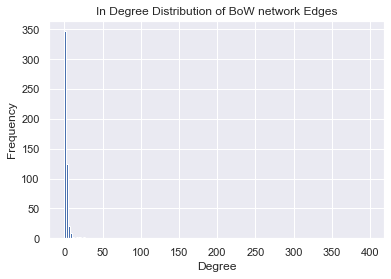

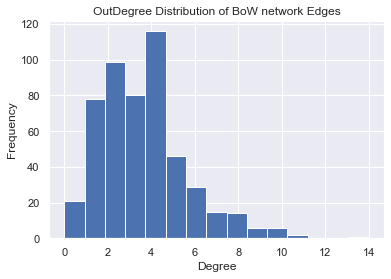

In [39]:
plt.hist(in_degrees, bins=150)
plt.title('In Degree Distribution of BoW network Edges')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

plt.hist(out_degrees, bins=15)
plt.title('OutDegree Distribution of BoW network Edges')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

The distributions show how the range of the in degree distribution goes up to approximately 400 whereas the out-degree distribution only ranges between 0 and 14. The reason for this is rather simple. The in-going edges are the accumulated edges from all the characters in the network. Whereas the out-going degrees are edges that goes out from a character, i.e. this character links to other charahcters. Therefore it is natural that the out-going degrees has a much narrower range than the in-going degrees distribution since it is more likely to get linked once by each character in the network than a character mentioning every character in the network.  

In [40]:
ingoing_gamma = powerlaw.Fit(in_degrees).alpha
outgoing_gamma = powerlaw.Fit(out_degrees).alpha

print('Exponent of ingoing degree distribution:: {}'.format(ingoing_gamma))
print('Exponent of outgoing degree distribution:: {}'.format(outgoing_gamma))

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Exponent of ingoing degree distribution:: 3.3014394185543834
Exponent of outgoing degree distribution:: 18.074798743853236


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


We see that both of the distributions (ingoing and outgoing) has an exponent greater than 3. This indicates that the network is more random than scale-free. This means that all nodes have comparable degrees and huge hubs shouldn't be present. We do know that Link has 408 connections, way more than the second most connected character with 62 connections. This indicates that Link is a big hub in the whole network. But besides Link, the vast majority has comparable degree distributions (both in and out-going edges) and thus opens up to the small world properties. 

To generate a random network, we must estimate the probability $p$ by $p = \frac{<k>}{N-1}$. 

In [41]:
k = np.mean(np.array(in_degrees) + out_degrees)
N = G.number_of_nodes()
p = k/(N-1)

In [42]:
G_random = nx.erdos_renyi_graph(N,p)
degrees = np.array([G_random.degree(node) for node in G_random.nodes()])
random_density, random_bins = np.histogram(degrees, bins=500)

In [43]:
density, bins = np.histogram(np.array(in_degrees+out_degrees), bins=500)

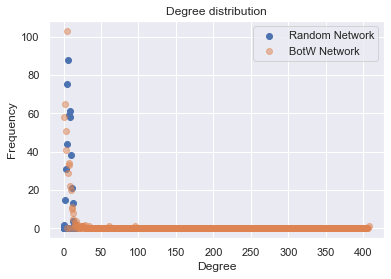

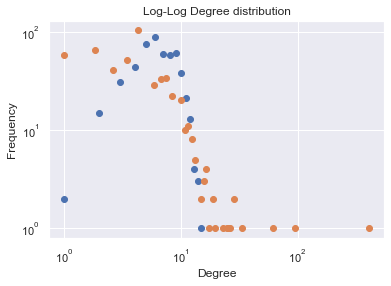

In [44]:
plt.scatter(random_bins[:-1], random_density, label='Random Network')
plt.scatter(bins[:-1], density, alpha=0.5, label='BotW Network')
plt.title('Degree distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.scatter(random_bins[:-1], random_density, label='Random Network')
plt.scatter(bins[:-1], density, label='BotW Network')
plt.title('Log-Log Degree distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.xscale('log')
plt.yscale('log')
plt.show()

The distributions seems similar when degree > 5. They deviate a lot in the low range of degrees where the BotW network has more nodes with very few connections. Moreover, the BotW network has higher values of degrees whereas the random network does not have degrees > 15. This therefore may indicate that the BotW network could also be a scale-free network due to the more frequent "extreme values" but the distribution doesn't seem to follow any kind of linear line in the log-log plot. 

### Exercise 1.b

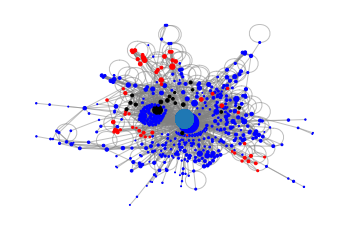

In [46]:
role_color_mapping = {'Ally': 'blue', 'Enemy': 'red', 'Boss':'black'}
colors = [role_color_mapping[node_dict['role']] for _, node_dict in G.nodes(data=True)]
sizes = [G.degree(node) for node in G.nodes()]

Gcc = sorted(nx.connected_components(G.to_undirected()), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
H0 = G0.to_undirected()
colors = [role_color_mapping[node_dict['role']] for _, node_dict in G0.nodes(data=True)]
sizes = [G.degree(node) for node in G0.nodes()]
positions = forceatlas2.forceatlas2_networkx_layout(H0, pos=None, niter = 100)
nx.draw_networkx_nodes(H0, positions, node_size=sizes, node_color=colors)
nx.draw_networkx_edges(H0, positions, edge_color='gray', alpha=0.5)
nx.draw(G0)

It is hard to see anything in the plot. But a large blue node is present in the middle which seems to be connected to almost everyone in the network. It is very likely that this node is Link since he was the most connected character in the network. 

# Part 2: Word-clouds

Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from the ZeldaWiki pages.

Here's what you need to do:
> * Create a word-cloud for each race of the [five champions of Hyrule](https://zelda.fandom.com/wiki/Champions) (i.e. Hylian, Zora, Goron, Gerudo, and Rito) according to either TC-IDF. Feel free to make it as fancy as you like. Explain your process and comment on your results.

In [47]:
import os
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

### calculate IDF (Inverse Document Frequency)

In [48]:
# file: ./totalCorpusOfBtow.txt 
# Include corpus from each race document
text=open('./totalCorpusOfBtow.txt').read()
tokenizer=WordPunctTokenizer()
tokens = tokenizer.tokenize(text)
tokens = [w.lower() for w in tokens if w.isalpha() and w not in stopwords.words('english')]

# The IDF calculation is based on sklearn lib
cv = CountVectorizer()
word_count_vector = cv.fit_transform(tokens)

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit_transform(tokens)

idf = pd.DataFrame({'feature_name':cv.get_feature_names(), 'idf_weights':tfidf_vectorizer.idf_})

# set index of dataframe
idf.set_index(['feature_name'],inplace=True)

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### calculate TC_IDF for five champions of Hyrule

In [49]:
# folder: ./zeldaRaceCorpus/ 
# Include corpus document of each race
racepath='./zeldaRaceCorpus/'
racefiles=os.listdir(racepath)

In [50]:
races =['Hylian', 'Zora', 'Goron', 'Gerudo', 'Rito']

race_tc_idf={}
for race in races: 
    # read file that contains tokens of each race (one long string)
    text = open(racepath+race+'.txt').read()
    
    # tokenize string
    tokens = tokenizer.tokenize(text)
    # exclude punc and stopwords
    tokens = [w.lower() for w in tokens if w.isalpha() and w not in stopwords.words('english')]
    
    # calculate TC (Term Count)
    tc= dict(nltk.FreqDist(tokens))
    
    # calculate TC-IDF (TC*IDF)
    tc_idf = dict.fromkeys(tokens,0)
    for token in tokens:
        try: 
            tc_idf[token]=tc[token]*round(idf.loc[token,'idf_weights'])
        except:
        # some weired tokens not exist when calculating IDF, so chose to pass it
            pass
    # save tc_idf for each race
    race_tc_idf[race] =  tc_idf

### plot wordcloud for five races

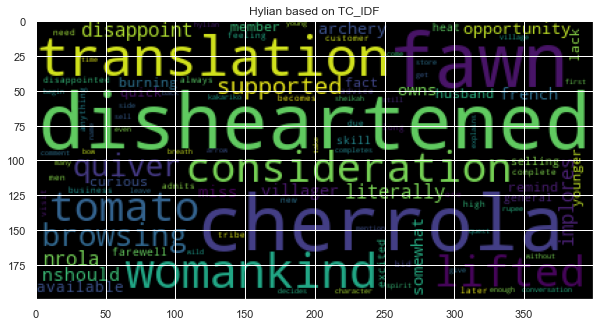

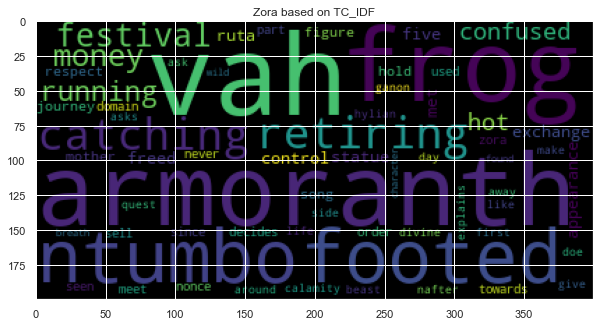

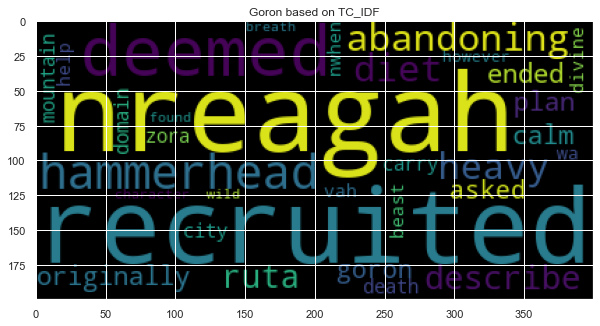

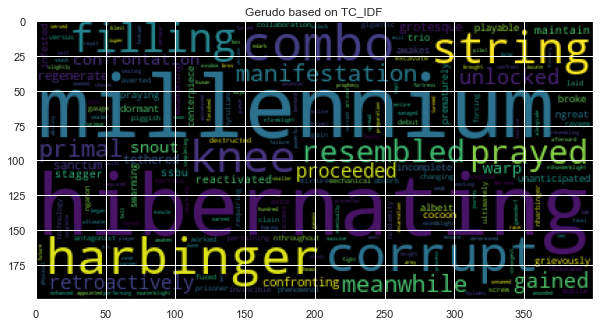

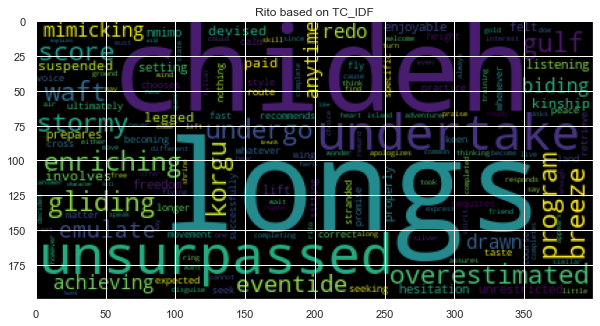

In [51]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

i=0
for race in races:
    wc = WordCloud(collocations = False).generate_from_frequencies(race_tc_idf[race])
    plt.figure(figsize=(10,50))

    i=i+1
    plt.subplot(5,1,i)
    plt.title(race+' based on TC_IDF')
    plt.imshow(wc)

# Part 3: Communities and TF-IDF

Find communities and compute their associated TF-IDF (from lecture 7 and 8).

Here's what you need to do:
> * Explain the Louvain algorithm and how it finds communities in a newtork.
> * Explain how you chose to identify the communities: Which algorithm did you use? (if you did not use the Louvain method, explain how the method you have used works) 
> * Comment your results:
>   * How many communities did you find in total?
>   * Compute the value of modularity with the partition created by the algorithm.
>   * Plot the distribution of community sizes.
> * For the 5 largest communities, create TF-IDF based rankings of words in each community. 
>   * There are many ways to calculate TF-IDF, explain how you've done it and motivate your choices.
>   * List the 5 top words for each community according to TF.
>   * List the 5 top words for each community accourding to TF-IDF. Are these words more descriptive of the community than just the TF? Justify your answer.

In [52]:
import community
import networkx as nx
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import forceatlas2
from matplotlib.pyplot import cm
sns.set_theme()

We are going to use Louvain's algorithm to find the communities in the network. The algorithm works by first assigning each node to its own community. Then it starts changing each node to another community and checks how this affects the modularity of the network. If the modularity increases, the node is changed to the other community and otherwise left in its original community. After optimizing for the modulairty by switching all nodes to different communities, the algorithm then aggregates all nodes that belong to the same community and handles the community as a single node. Hereafter the algorithm again optimizes for the modularity and continues doing these two steps until there are no change in modularity whereafter the algorithm terminates. 

In [53]:
H = G.to_undirected()
Hcc = sorted(nx.connected_components(H), key=len, reverse=True)
H = H.subgraph(Hcc[0])

partition = community.best_partition(H)
print('Number of communities:: {}'.format(len(set(partition.values()))))

Number of communities:: 21


Storing all members of each community in its each set. 

In [54]:
characters = set(partition.values())
communities = []
for name in characters:
    communities.append({k for k in partition.keys() if partition[k] == name})

In [58]:
modularity = nx.algorithms.community.modularity(H, communities)
print('Modularity of BotW network is {}'.format(round(modularity, 2)))

Modularity of BotW network is 0.61


In [59]:
comm_sizes = [len(community) for community in communities]

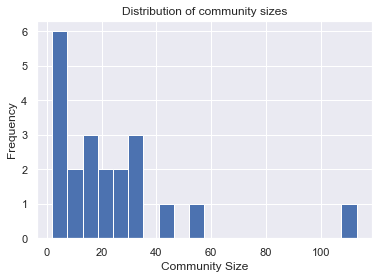

In [60]:
plt.hist(comm_sizes, bins=20)
plt.title('Distribution of community sizes')
plt.xlabel('Community Size')
plt.ylabel('Frequency')
plt.show()

As the histogram shows, most communities has a size below 40 but 3 communities obtain sizes greater than 40 and one of the has a size of around 120. This means that there is a wide span of sizes of the communities in the network. 

We will now tompute the 5 most common words in each community using the TI-IDF score. We will do this by reading the character page of each character within a group. All these pages within a group will be concatenated to a large string such that we end up with #communities strings. 

In [61]:
def community_texts(community):
    comm_pages = []
    for character in community:
        with open('files/' + re.sub(' ', '_', character) + '.txt', 'r') as f:
            character_content = f.read()
            comm_pages.append(character_content)
    return comm_pages

Each string will be preprocessed s.t. the stopwords are removed, are words are in lower case, all special characters are removed and all words are lemmatized. 

In [62]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [63]:
def preprocess_texts(comm_texts):
    cleaned_texts = []
    for text in comm_texts:
        tokens = word_tokenize(text)
        words = [word for word in tokens if word.isalpha()]
        words = [word for word in words if not word in stop_words]
        words = [word.lower() for word in words]
        words = [lemmatizer.lemmatize(word) for word in words]
        cleaned_texts.append(words)
    return cleaned_texts

In [67]:
all_cleaned_texts = []
for comm in communities:
    comm_texts = community_texts(comm)
    comm_texts_cleaned = preprocess_texts(comm_texts)
    comm_texts_cleaned[1].count('botw')
    comm_texts = [item for sublist in comm_texts_cleaned for item in sublist]
    all_cleaned_texts.append(comm_texts)

In [68]:
def compute_tf(word, documents):
    counts_in_documents = np.zeros(len(documents))
    for i, document in enumerate(documents):
        counts_in_documents[i] += document.count(word)
    ti = counts_in_documents / np.array([len(document) for document in documents])
    return ti

def compute_idf(word, documents):
    contained_in_documents = 0
    for document in documents:
        if word in document:
            contained_in_documents += 1
    
    idf = np.log(len(documents) / contained_in_documents)
    return idf

def compute_ti_idfs(documents):
    bagofwords = []
    for document in documents:
        bagofwords += document
    bagofwords = list(set(bagofwords))
    print('Number of unique words:: {}'.format(len(bagofwords)))
    
    tf_s = np.zeros((len(bagofwords), len(documents)))
    idf_s = np.zeros((1, len(bagofwords)))
    tf_idf_s = np.zeros((len(bagofwords), len(documents)))

    for i, word in enumerate(bagofwords):
        tf_s[i, :] = compute_tf(word, documents)
        idf_s[0, i] = compute_idf(word, documents)
        tf_idf_s[i, :] = tf_s[i, :] * idf_s[0, i]
    
    top5_indeces_tf_idf = np.argsort(tf_idf_s, axis=0)[::-1][:5]
    top5_indeces_tf = np.argsort(tf_s, axis=0)[::-1][:5]
    
    top5_words_tf = {}
    for group in range(len(documents)):
        top5_words_tf.update({group: [bagofwords[i] for i in top5_indeces_tf[:, group]]})
    
    top5_words_tf_idf = {}
    for group in range(len(documents)):
        top5_words_tf_idf.update({group: [bagofwords[i] for i in top5_indeces_tf_idf[:, group]]})

    return top5_words_tf, top5_words_tf_idf

In [69]:
top5_tf, top5_tf_idf = compute_ti_idfs(all_cleaned_texts)
print('Top 5 words for each group (TF / TF IDF)')
for group_num in range(len(top5_tf)):
    print('Group {}'.format(group_num))
    for i in range(5):
        print('{}.: {}, {}'.format(i, top5_tf[group_num][i], top5_tf_idf[group_num][i]))
    print('\n')

Number of unique words:: 10279
Top 5 words for each group (TF / TF IDF)
Group 0
0.: horse, baddek
1.: ref, horse
2.: stable, dauntless
3.: botw, nazbi
4.: i, grain


Group 1
0.: ref, surfer
1.: shield, surfing
2.: i, bamboo
3.: mountain, selmie
4.: surfing, baumar


Group 2
0.: ref, epona
1.: horse, jana
2.: link, horse
3.: i, gleema
4.: epona, register


Group 3
0.: ref, izra
1.: botw, ami
2.: izra, yolero
3.: know, wetland
4.: character, passage


Group 4
0.: ref, moblin
1.: link, moblins
2.: br, octorok
3.: moblin, lynel
4.: file, beedle


Group 5
0.: ref, pelison
1.: i, rhondson
2.: botw, hudson
3.: link, greyson
4.: he, tarrey


Group 6
0.: ref, stalker
1.: i, guardian
2.: guardian, scout
3.: botw, brigo
4.: link, turret


Group 7
0.: ref, bozai
1.: link, hestu
2.: i, horse
3.: botw, gerudo
4.: if, frelly


Group 8
0.: ref, bokoblin
1.: bokoblin, lizalfos
2.: botw, sesami
3.: lizalfos, shabonne
4.: file, talus


Group 9
0.: ref, riju
1.: i, traysi
2.: link, buliara
3.: gerudo, urb

Above is shown the 5 most common words in each of the groups. The word on the left side is the most common words based on the TF score and the words on the right is based on the TF-IDF score. As you see, the left side is filled with more common 'meaningless' words such as botw, he, if, file etc. Whereas the right sided words has a most semantic meaning such as guardian, surfer, horned etc. The TF-IDF score is therefore a good measure to prevent getting words that are very common but not meaningful when used in a sentence. 

# Part 4: Sentiment of communities

Analyze the sentiment of the communities (lecture 8). Here, we assume that you've successfully identified communities.  More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below:
* We name each community by its three most connected characters.
* Average the average sentiment of the nodes in each community to find a community level sentiment.

Here's what you need to do (repeat these steps and report your results for **both LabMT and VADER**):
> * Calculate and store sentiment for every character
> * Create a histogram of all character's associated sentiments.
> * What are the 10 characters with happiest and saddest pages?

Now, compute the sentiment of communities: 
> * What are the three happiest communities according to the LabMT wordlist approach? What about VADER?
> * What are the three saddest communities according to the LabMT wordlist approach? What about VADER?
> * Create a bar plot showing the average sentiment of each community and add error-bars using the standard deviation for both methods. 
> * Explain the difference between the two methods and compare the results you have obtained above.
> * What is the advantage of using a rule-based method over the dictionary-based approach? 

In [1]:
import pandas as pd
import numpy as np

import json
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

import matplotlib.pyplot as plt

In [2]:
# open the role dialogues file
f = open('./CharactersDialogue.json')
role_dialogues= json.loads(f.read())

### LabMT Calculate and store sentiment for every character

In [3]:
# read labMt file as csvfile
labMt_df=pd.read_csv('./Data_Set_S1.txt',sep='\t',index_col=0)

In [4]:
# a function that calculates sentiment given a list of tokens
def sentimentByMT(role):
    #init counting vars
    happycount=0
    wordcount=0
    
    # tokenize each sentence in role dialogues,calculate the average sentiment of every character.
    for sent in role_dialogues[role]:       
    # tokenize the sentences
        tokens = word_tokenize(sent)
    # lemmatize
        wnl=WordNetLemmatizer()
        lemmatizedTokens = [wnl.lemmatize(t) for t in tokens]
    # set to lower case
    # # use FreDist so we can calculate every unique word only once
        fd_tokens = FreqDist(t.lower() for t in lemmatizedTokens)

        for word in fd_tokens:
            if word in labMt_df.index:
                happycount+=labMt_df.loc[word,'happiness_average']*fd_tokens[word]
                wordcount+=fd_tokens[word]
        
    role_have = happycount/wordcount
        
    return role_have

In [5]:
# Iterate each role in Btow, and calculate average sentiment of each role
role_have_mt={}

for role in role_dialogues.keys():
    role_have_mt[role] = sentimentByMT(role)

### VADER Calculate and store sentiment for every character
sentiment intensity on a scale from –4 to +4

In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [7]:
def sentimentByVader(role):
    have_count = 0
    
    for sent in role_dialogues[role]:       
        vs = analyzer.polarity_scores(sent)
        #  compound: -1 (most extreme negative) and +1 (most extreme positive)
        have_count += vs['compound']
    
    role_have = have_count/len(role_dialogues[role])
    return role_have

In [8]:
# save the H_ave for each role
role_have_va={}

In [9]:
# Iterate each role in Btow, average sentiment of each role
for role in role_dialogues.keys():         
    role_have_va[role] = sentimentByVader(role)

### What are the 10 characters with happiest and saddest pages? ( LabMT and VADER )

In [10]:
# 10 characters with happiest pages by LabMT
FreqDist(role_have_mt).most_common(10)

[('Zooki', 6.068571428571429),
 ('Kinov', 5.966071428571429),
 ('Narah', 5.909270833333335),
 ('Tasho', 5.8416),
 ('Kula', 5.794139784946235),
 ('Toren', 5.787142857142858),
 ('Katta', 5.753548387096773),
 ('Notts', 5.74242603550296),
 ('Shamae', 5.741728395061728),
 ('Pepp', 5.7356457564575685)]

In [11]:
# 10 characters with happiest pages by VADER
FreqDist(role_have_va).most_common(10)

[('Zooki', 0.8879),
 ('Canni', 0.7099500000000001),
 ('Breen', 0.7099500000000001),
 ('Toren', 0.64975),
 ('Peeks', 0.63227),
 ('Harlow', 0.6309),
 ('Zyle', 0.6140800000000001),
 ('Nazbi', 0.6009000000000001),
 ('Sebasto', 0.5723),
 ('Kula', 0.5655545454545454)]

In [12]:
# 10 characters with saddest pages by LabMT
import collections
c_mt = collections.Counter(role_have_mt)
c_mt.most_common()[:-11:-1]

[('Aya', 5.165),
 ('Kotta', 5.171487603305789),
 ('Kenyo', 5.174285714285716),
 ('Walton', 5.19),
 ('Bargoh', 5.213692307692314),
 ('Flaxel', 5.23504132231405),
 ('Strade', 5.246338028169017),
 ('Palme', 5.257241379310345),
 ('Drak', 5.2688484848484896),
 ('Sudrey', 5.270297029702972)]

In [13]:
# 10 characters with saddest pages by VADER
c_va = collections.Counter(role_have_va)
c_va.most_common()[:-11:-1]

[('Palme', -0.6656),
 ('Kotta', -0.46567),
 ('Princess Zelda', -0.3501222222222223),
 ('Sumati', -0.1640142857142857),
 ('Monkton', -0.1501),
 ('Flaxel', -0.14678333333333335),
 ('Master Kohga', -0.13343333333333332),
 ('Kotts', -0.12361052631578946),
 ('Strade', -0.11460799999999999),
 ('Rik', -0.1127)]

### Create a histogram of all character's associated sentiments.  ( LabMT and VADER )


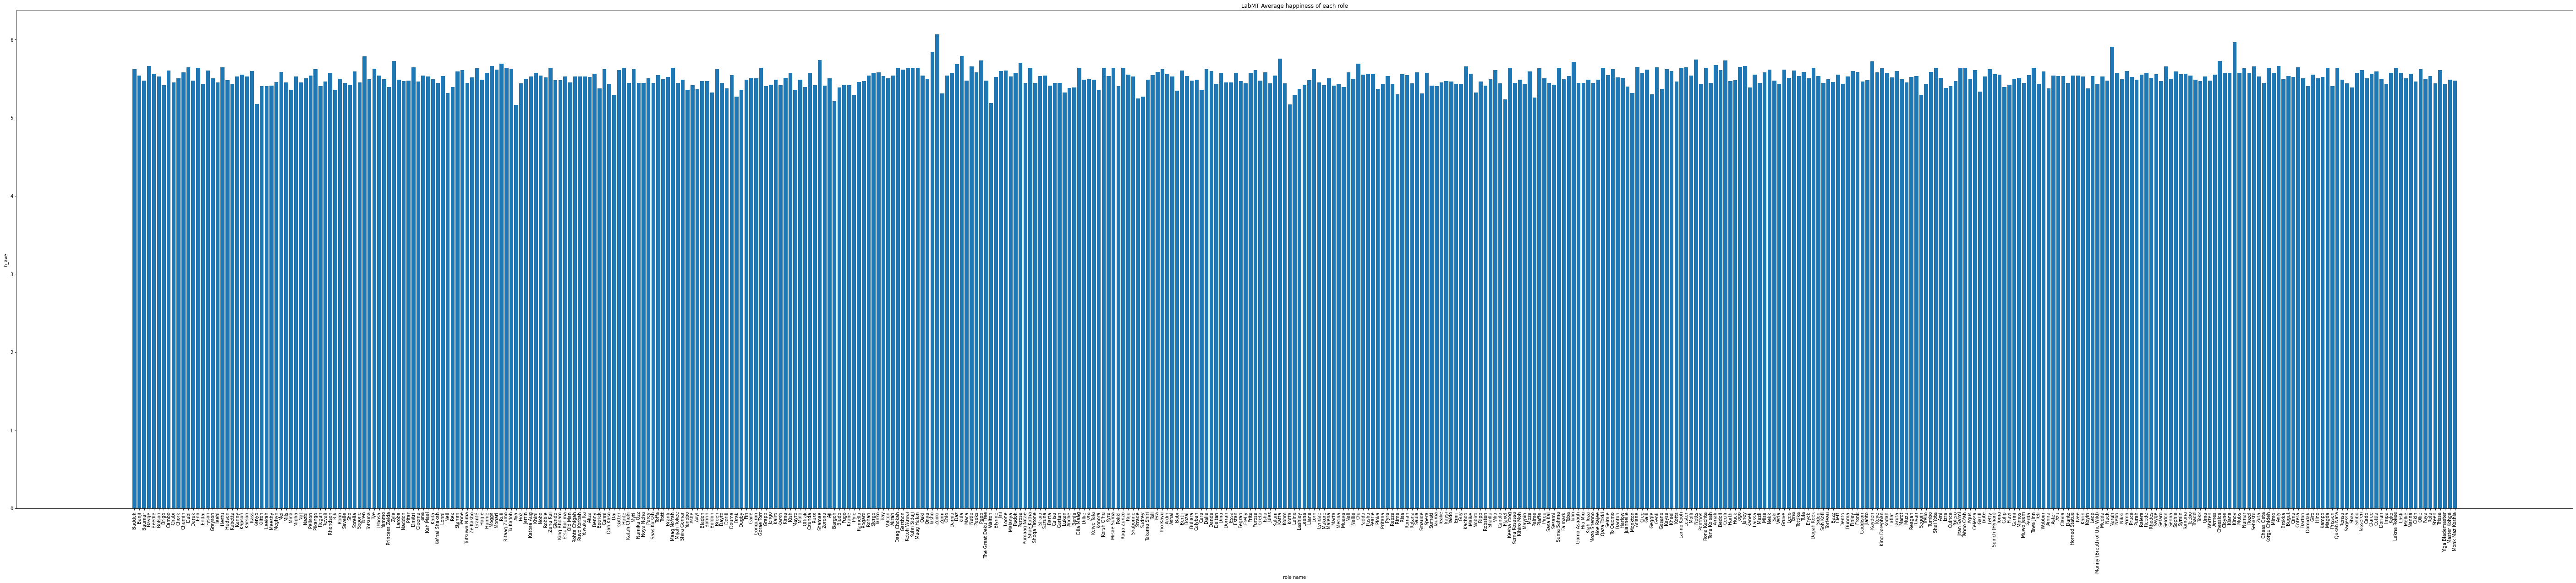

In [14]:
# Plot role-sentiment histigram by LabMT
plt.figure(figsize = (100,20))
plt.xlabel('role name')
plt.xticks(rotation=90)
plt.ylabel('h_ave')
plt.title('LabMT Average happiness of each role')
plt.bar(list(role_have_mt.keys()), role_have_mt.values())
plt.show()

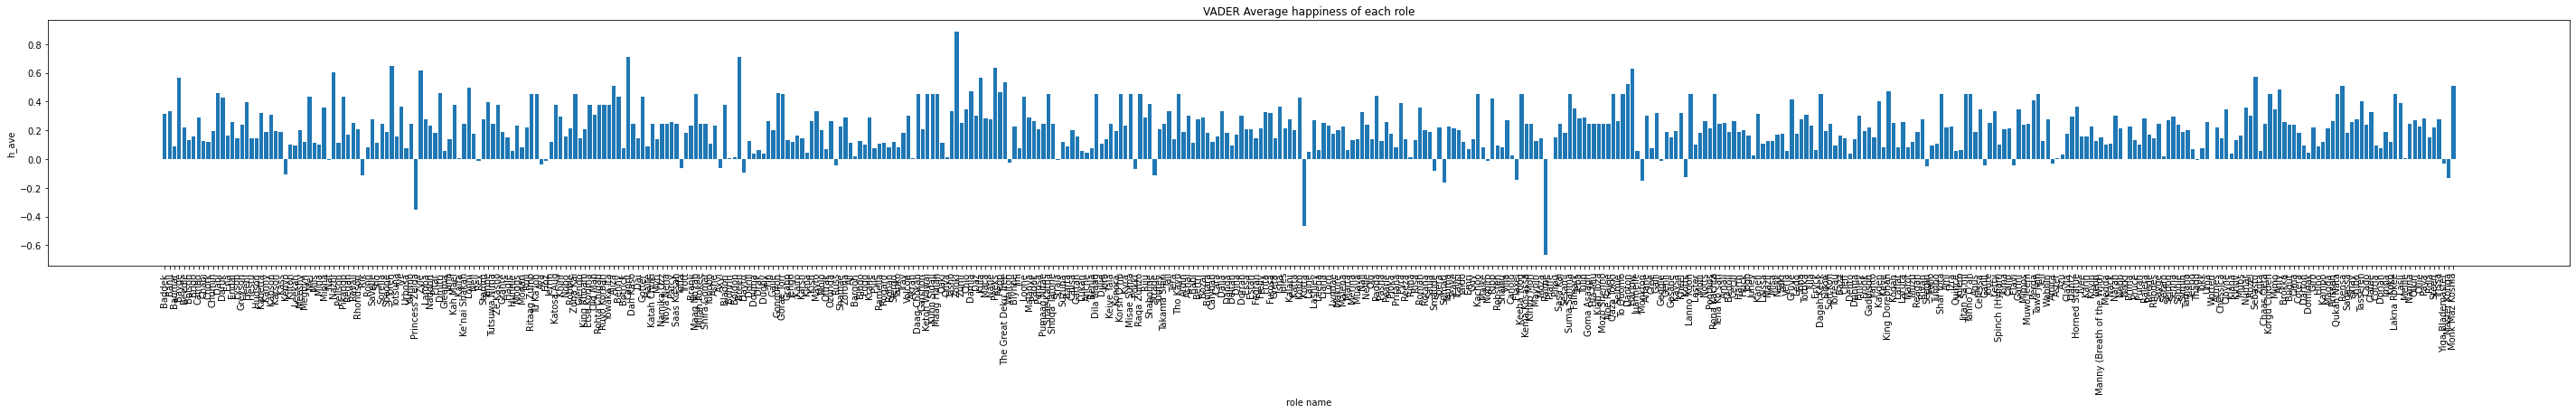

In [15]:
# Plot role-sentiment histigram by VADER
plt.figure(figsize = (50,5))
plt.xlabel('role name')
plt.xticks(rotation=90)
plt.ylabel('h_ave')
plt.title('VADER Average happiness of each role')
plt.bar(list(role_have_va.keys()), role_have_va.values())
plt.show()

### Compute the sentiment of communities

In [16]:
# This file contains the communities in BtoW found by Louvain-algorithm
# key: its three most connected characters, value: roloes in each community
f = open('./btow_community.json')
coms = json.loads(f.read())

In [17]:
com_have_mt={}
for cname in coms.keys():
    
    # calculate the sentiment of each role in same community 
    have_count = 0 
    for role in coms[cname]:
        if role in role_dialogues.keys():
            have_count += sentimentByMT(role)
    
    # get average sentiment of each cummunity
    com_have_mt[cname] = have_count/len(coms[cname])

In [18]:
com_have_va={}
for cname in coms.keys():
    
    # calculate the sentiment of each role in same community 
    have_count = 0 
    for role in coms[cname]:
        if role in role_dialogues.keys():
            have_count += sentimentByVader(role)
    
    # get average sentiment of each cummunity
    com_have_va[cname] = have_count/len(coms[cname])

### What are the three happiest communities according to the LabMT wordlist approach? What about VADER?

In [19]:
have_mt = sorted(com_have_mt.items(), key = lambda pair:pair[1],reverse=True)[:3]
have_va = sorted(com_have_va.items(), key = lambda pair:pair[1],reverse=True)[:3]
print('The three happiest communities according to the LabMT:\n',have_mt[0][0],'\n',have_mt[1][0],'\n',have_mt[2][0],'\n')
print('The three happiest communities according to the VADER:\n',have_va[0][0],'\n',have_va[1][0],'\n',have_va[2][0])

The three happiest communities according to the LabMT:
 Horned Statue_Medda_Senna 
 Jiahto_Douma_Cleff 
 Zumi_Onya_Garshon 

The three happiest communities according to the VADER:
 Kah Mael_Ke'nai Shakah_Tutsuwa Nima 
 Canni_Shamae_Endai 
 Jiahto_Douma_Cleff


### What are the three saddest communities according to the LabMT wordlist approach? What about VADER?

In [20]:
have_mt = sorted(com_have_mt.items(), key = lambda pair:pair[1])[:3]
have_va = sorted(com_have_va.items(), key = lambda pair:pair[1])[:3]
print('The three saddest communities according to the LabMT:\n',have_mt[0][0],'\n',have_mt[1][0],'\n',have_mt[2][0],'\n')
print('The three saddest communities according to the VADER:\n',have_va[0][0],'\n',have_va[1][0],'\n',have_va[2][0])

The three saddest communities according to the LabMT:
 Harry (Breath of the Wild)_Mary (Breath of the Wild)_Monkton 
 Spoone_Glendo_Dai 
 Kanny_Tye_Rock Octorok 

The three saddest communities according to the VADER:
 Harry (Breath of the Wild)_Mary (Breath of the Wild)_Monkton 
 Quince_Satty 
 Spoone_Glendo_Dai


### Create a bar plot showing the average sentiment of each community and add error-bars using the standard deviation for both methods.

In [21]:
import statistics

#calculate standard error LabMT
std_error_mt = statistics.pstdev(com_have_mt.values())
#calculate standard error VADER
std_error_va = statistics.pstdev(com_have_va.values())
# visualise the standard deviation
std_error_mt, std_error_va

(1.4454732619654804, 0.08562356897888934)

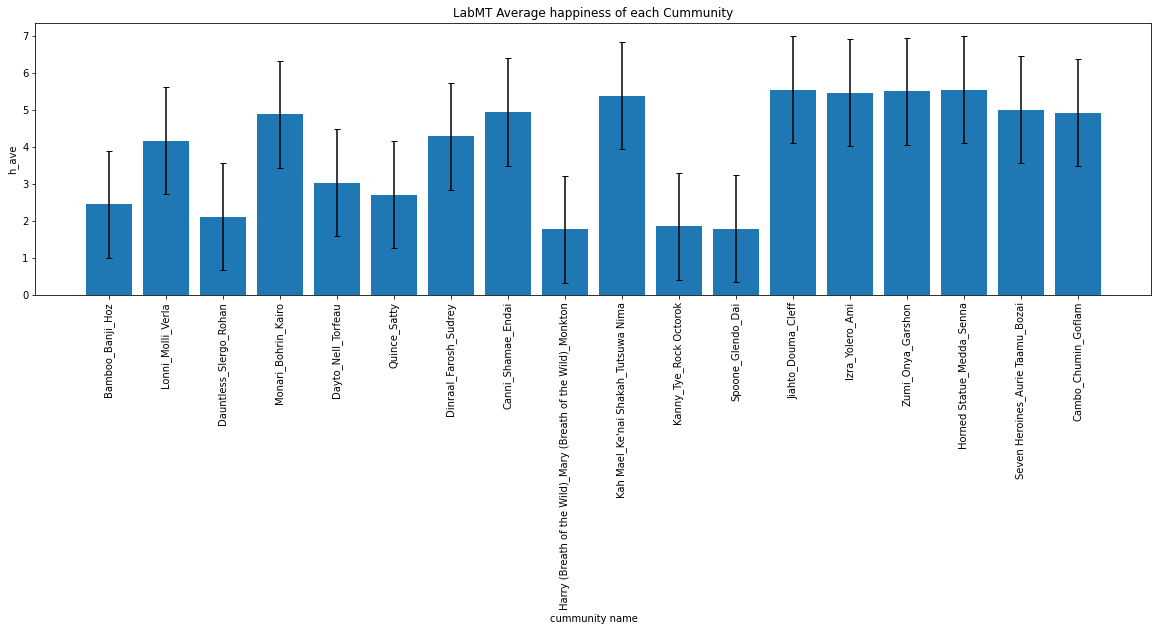

In [22]:
plt.figure(figsize = (20,5))
plt.xlabel('cummunity name')
plt.xticks(rotation=90)
plt.ylabel('h_ave')
plt.title('LabMT Average happiness of each Cummunity')
plt.bar(list(com_have_mt.keys()), com_have_mt.values(),yerr=std_error_mt,capsize=3)
plt.show()

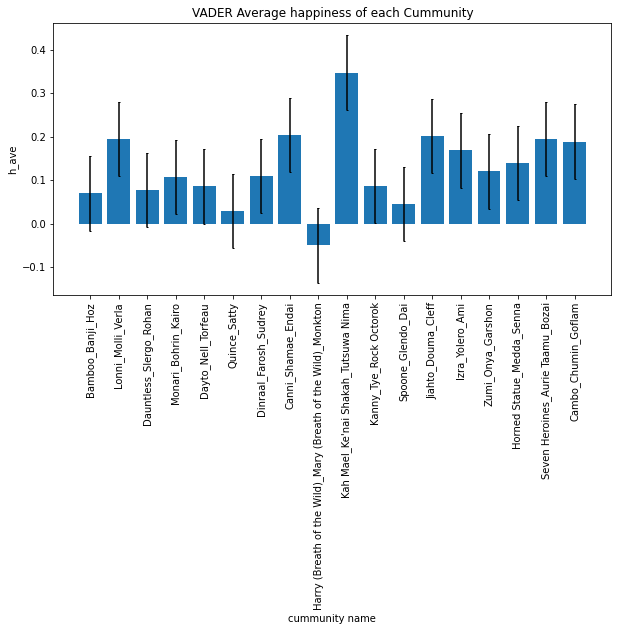

In [23]:
plt.figure(figsize = (10,5))
plt.xlabel('cummunity name')
plt.xticks(rotation=90)
plt.ylabel('h_ave')
plt.title('VADER Average happiness of each Cummunity')
plt.bar(list(com_have_va.keys()), com_have_va.values(),yerr=std_error_va,capsize=1)
plt.show()

### Explain the difference between the two methods and compare the results you have obtained above.

LabMT Sentiment Analysis is dictionary-based. The words are ordered according to average happiness from 1-9. While Vader Sentiment Analysis is based on a dictionary of words related to emotions. Every word in the dictionary is rated as positive or negative. 

Form the two pictures above, we can see that the average sentiment between each community based on Vader Sentiment Analysis has smaller gap than based on LabMT Sentiment Analysis. 

### What is the advantage of using a rule-based method over the dictionary-based approach?
When analyzing comments or text from social media, the sentiment of the sentence changes according to the emoji. Vader takes this into account along with slang, capitalization, etc., so it is a better choice in terms of tweet analysis and sentiment.